# <font color=#cd0000> Propósito principal </font>
- La idea de este librillo es preparar el entorno para realizar pruebas para ``Epilepsy`` a ser clasificado con las series en bruto con RF.

## <font color=#cd0000> Leyenda </font>
- Los apartados titulados con el código de colores HEX: `#cd0000` serán apartados que tendrán todos los librillos, en concreto, aquellos especificados en el apartado `Síntesis de los criterios usados` del trabajo.
- Los apartados titulados con el código de colores HEX: `#2451ff` serán apartados de conclusiones propias de este librillo resultado de aplicar un estudio personalizado para cada planteamiento.

# <font color=#cd0000> Prerrequisitos </font>
## <font color=#cd0000> Entorno de ejecución </font>
- Cambiamos el directorio raíz del librillo para acceder cómodamente a las funciones de utilidad.

In [1]:
import os

os.chdir('../../../../')
os.listdir()


['.git',
 '.gitignore',
 '.gitmodules',
 'data',
 'pkl',
 'Pruebas',
 'README.md',
 'smts_implementation',
 'utils']

## <font color=#cd0000> Constantes y variables predefinidas </font>

In [2]:
EPILEPSY_PATH = "data/epilepsy"

DATA_TO_SAVE = "Epilepsy"

PKL_DIR = "pkl/RF/Epilepsy/"
PKL_NAME = "epilepsy_RF_raw.pkl"

SEED = 1


# <font color=#cd0000> Carga del Dataset </font>

In [3]:
from utils.load_data import import_epilepsy_dataset

train, test = import_epilepsy_dataset(EPILEPSY_PATH)

In [4]:
train.reset_changes()
test.reset_changes()


# <font color=#cd0000> Preprocesamiento </font>

## <font color=#cd0000> Eliminación de datos inválidos y valores atípicos </font>
- Eliminaremos aquellos valores fuera de los percentiles 5 y 95.
- El grado de outliers mínimo en, al menos, una dimensión para eliminar una serie temporal será del 80% (si más del 80% de los datos son anómalos descartamos la serie).
  - A pesar de que esto pueda parecer muy grande debemos comprender que, la probabilidad con la que aparezca ruido en una de las dimensiones de una serie temporal multivariada, es muy alta (tenemos varias series temporales con ruido cada una).

In [5]:
train.remove_outliers(
    headers=train.get_derived_data_columns()['attrs'],
    outliers_limit=.8
)

test.remove_outliers(
    headers=test.get_derived_data_columns()['attrs'],
    outliers_limit=.8
)


In [6]:
import pandas as pd

# Remaining series
print("Train: Previous number of series: {}".format(
    len(pd.unique(train.original_data['id']))))
print("Train: Actual number of series: {}".format(
    len(pd.unique(train.derived_data['id']))))

print("Test: Previous number of series: {}".format(
    len(pd.unique(test.original_data['id']))))
print("Test: Actual number of series: {}".format(
    len(pd.unique(test.derived_data['id']))))


Train: Previous number of series: 137
Train: Actual number of series: 137
Test: Previous number of series: 138
Test: Actual number of series: 138


## <font color=#cd0000> Resoluciones a aplicar </font>
- Como concluimos en el análisis en profundidad, mantendremos la resolución original.

In [7]:
# Nothing to see here

# <font color=#cd0000> División en ventanas </font>
- Como concluimos en el análisis en profundidad no aplicaremos enventanado pues las series son muy cortas y, aplicar un enventanado que divida las series en subseries, daría como resultado series mucho más cortas de las que sería más difícil extraer patrones en el caso de clases como ``epilepsy``, por ejemplo.

In [8]:
# Nothing to see here

## <font color=#cd0000> Codificación </font>
- Series originales (no aplicamos ninguna codificación extra)

In [9]:
# Nothing to see here

# <font color=#cd0000> Preparación de los datos </font>

In [10]:
X_train = train.derived_data.drop(['id', 'class'], axis=1)
X_test = test.derived_data.drop(['id', 'class'], axis=1)

y_train = train.derived_data['class'].to_numpy()
y_test = test.derived_data['class'].to_numpy()

## <font color=#cd0000> Técnicas de balanceo </font>

### <font color=#cd0000> Asignación de pesos a las clases </font>

In [11]:
import numpy as np
from sklearn.utils import compute_class_weight

class_weights = compute_class_weight(
    'balanced', classes=np.unique(y_train), y=y_train)
class_weights = {'epilepsy': class_weights[0], 'running': class_weights[1],
                 'sawing': class_weights[2], 'walking': class_weights[3]}


# <font color=#cd0000> Diseño de la topología del bosque </font>
- Número de estimadores inicial recomendado
- Profundidad máxima recomendada

## <font color=#cd0000> Entrenamiento </font>

In [30]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=SEED,
    class_weight=class_weights
)
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight={'epilepsy': 1.0073529411764706,
                                     'running': 0.9513888888888888,
                                     'sawing': 1.1416666666666666,
                                     'walking': 0.9256756756756757},
                       max_depth=10, random_state=1)

## <font color=#cd0000> Clasificación </font>

In [31]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

y_pred = clf.predict(X_test)
y_true = np.asarray(y_test)
    
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, zero_division=0))


[[3582  676 2150  596]
 [1214 4392  752 1264]
 [ 934  225 4305  716]
 [ 768  528  776 5550]]
              precision    recall  f1-score   support

    epilepsy       0.55      0.51      0.53      7004
     running       0.75      0.58      0.65      7622
      sawing       0.54      0.70      0.61      6180
     walking       0.68      0.73      0.70      7622

    accuracy                           0.63     28428
   macro avg       0.63      0.63      0.62     28428
weighted avg       0.64      0.63      0.63     28428



## <font color=#cd0000> Discusión de los resultados </font>
- Vamos a estudiar diferentes rangos de hiper-parámetros interesantes que podrían darnos alguna pista sobre el rango en el que buscar el mejor clasificador de este tipo:
  - Para un `n_estimators` pequeño (10) y una `max_depth` pequeño (10) observamos resultados mejorables y suele clasificar mejor la clase mayoritaria ``walking``
    ```
    Confusion matrix:
    [[3586  690 2207  521]
     [1282 4322  782 1236]
     [ 957  222 4285  716]
     [ 955  481  799 5387]]

    Classification report:
                  precision    recall  f1-score   support

        epilepsy       0.53      0.51      0.52      7004
         running       0.76      0.57      0.65      7622
          sawing       0.53      0.69      0.60      6180
         walking       0.69      0.71      0.70      7622

        accuracy                           0.62     28428
       macro avg       0.63      0.62      0.62     28428
    weighted avg       0.63      0.62      0.62     28428
    ```
    - Para un `n_estimators` pequeño (10) y una `max_depth` grande (200) observamos resultados algo peores para todas las clases así que probaremos con un `max_depth` que sea la mitad de lo que es ahora:
    ```
    Confusion matrix:
    [[3661 1091 1710  542]
     [1303 4606  635 1078]
     [1299  553 3583  745]
     [ 824 1196  730 4872]]

    Classification report:
                      precision    recall  f1-score   support

        epilepsy       0.52      0.52      0.52      7004
         running       0.62      0.60      0.61      7622
          sawing       0.54      0.58      0.56      6180
         walking       0.67      0.64      0.66      7622

        accuracy                           0.59     28428
       macro avg       0.59      0.59      0.59     28428
    weighted avg       0.59      0.59      0.59     28428
    ```
    - Para un `n_estimators` pequeño (10) y una `max_depth` intermedio (100) observamos resultados exactamente iguales que para un `max_depth` de 200 por lo que ahora cambiaremos el `n_estimators` y dejaremos el `max_depth` en 10:
    ```
    Confusion matrix:
    [[3661 1091 1710  542]
     [1303 4606  635 1078]
     [1299  553 3583  745]
     [ 824 1196  730 4872]]

    Classification report:
                  precision    recall  f1-score   support

        epilepsy       0.52      0.52      0.52      7004
         running       0.62      0.60      0.61      7622
          sawing       0.54      0.58      0.56      6180
         walking       0.67      0.64      0.66      7622

        accuracy                           0.59     28428
       macro avg       0.59      0.59      0.59     28428
    weighted avg       0.59      0.59      0.59     28428
    ```
    - Para un `n_estimators` grande (200) y una `max_depth` pequeño (10) observamos resultados muy similares a los obtenidos al principio por lo que, finalmente, elegiremos un `n_estimators` intermedio:
    ```
    Confusion matrix:
    [[3569  682 2150  603]
     [1221 4398  750 1253]
     [ 934  211 4315  720]
     [ 771  529  773 5549]]

    Classification report:
                 precision    recall  f1-score   support

       epilepsy       0.55      0.51      0.53      7004
        running       0.76      0.58      0.65      7622
         sawing       0.54      0.70      0.61      6180
        walking       0.68      0.73      0.70      7622

       accuracy                           0.63     28428
      macro avg       0.63      0.63      0.62     28428
   weighted avg       0.64      0.63      0.63     28428
   ```

    - Para un `n_estimators` intermedio (100) y una `max_depth` pequeña (10) observamos resultados muy parecidos a los obtenidos al principio:
    ```
    Confusion matrix:
    [[3582  676 2150  596]
     [1214 4392  752 1264]
     [ 934  225 4305  716]
     [ 768  528  776 5550]]

    Classification report:
                   precision    recall  f1-score   support

       epilepsy       0.55      0.51      0.53      7004
        running       0.75      0.58      0.65      7622
         sawing       0.54      0.70      0.61      6180
        walking       0.68      0.73      0.70      7622

       accuracy                           0.63     28428
      macro avg       0.63      0.63      0.62     28428
   weighted avg       0.64      0.63      0.63     28428
   ```

## <font color=#cd0000> Conclusiones </font>
- Como podemos observar este clasificador no logra generalizar lo suficiente como para obtener resultados significativos.
- No obstante si no tuviéramos más remedio que utilizarlo de esta forma buscaríamos el mejor en el rango orientativo:
  - `n_estimators`: [10, 100]
  - `max_depth`: [10, 100]

# <font color=#cd0000> Randomized Search </font>
- Búsqueda de hiper-parámetros aleatoria con RF maximizando ``macro avg f1-score``

## <font color=#cd0000> Rangos de búsqueda </font>
- Como vimos anteriormente los rangos de búsqueda aleatoria de los mejores hiper-parámetros serán los siguientes

In [32]:
N_ESTIMATORS_RANGE = range(10, 100)
MAX_DEPTH_RANGE = range(10, 100)

In [33]:
import random
import pickle
import utils.constants as cs
from sklearn.ensemble import RandomForestClassifier
from utils.classifier_utils import (windowed_cross_val,
                                    compute_classification_reports_means)
from utils.plot_utils import pretty_print_classification_report_dict


def rf_randomized_search_cv(
        windowed_series,
        relation_with_series,
        prefix,
        class_weights,
        cv=5):
    global PKL_DIR
    all_clf_used = {}

    n_samples = 5
    n_estimators_list = random.sample(list(N_ESTIMATORS_RANGE), n_samples)
    max_depth_list = random.sample(list(MAX_DEPTH_RANGE), n_samples)

    best_hyp_params = None
    best_score = 0
    for n_estimators in n_estimators_list:
        for max_depth in max_depth_list:
            clf = RandomForestClassifier(
                n_estimators=n_estimators,
                max_depth=max_depth,
                random_state=SEED,
                class_weight=class_weights
            )

            reports = windowed_cross_val(
                clf,
                windowed_series,
                relation_with_series,
                estimator_type=cs.ESTIMATOR_SKLEARN,
                cv=cv,
                drop_columns=['id', 'class'],
                seed=SEED
            )
            mean_report = compute_classification_reports_means(reports)
            all_clf_used[(n_estimators, max_depth)] = mean_report

            if mean_report['macro avg']['f1-score'][0] >= best_score:
                best_score = mean_report['macro avg']['f1-score'][0]
                best_hyp_params = (n_estimators, max_depth)
                best_report = mean_report

            print("\t\t--------------ACTUAL BEST: N_Estimators={}; Max_Depth={}--------------"
                  .format(best_hyp_params[0], best_hyp_params[1]))
            pretty_print_classification_report_dict(best_report)
            print("\t\t--------------ITERATION: N_Estimators={}; Max_Depth={}--------------"
                  .format(n_estimators, max_depth))
            pretty_print_classification_report_dict(mean_report)

    with open(PKL_DIR + prefix, 'wb') as file:
        pickle.dump(all_clf_used, file)

    return best_hyp_params, best_report


In [34]:
rf_randomized_search_cv(
    train.derived_data,
    train.derived_data_windows_per_serie,
    PKL_NAME,
    class_weights,
    cv=5)


		--------------ACTUAL BEST: N_Estimators=19; Max_Depth=25--------------
Accuracy: 0.5988059368374066 +/- 0.012261278108525165
epilepsy:
	precision: 0.527082017541769 +/- 0.10459686792337801
	recall: 0.5297541994143936 +/- 0.03750731668469811
	f1-score: 0.5195415520527364 +/- 0.045994044837400334
	support: 1400.8 +/- 329.6
running:
	precision: 0.6074937116634329 +/- 0.08381893121188952
	recall: 0.5916400832177531 +/- 0.03158919758176878
	f1-score: 0.5951934220502392 +/- 0.04250621495587996
	support: 1483.2 +/- 240.2352180676264
sawing:
	precision: 0.5846588205629033 +/- 0.059770583472948356
	recall: 0.6203975959315765 +/- 0.032662896444958726
	f1-score: 0.6003561123399063 +/- 0.03781844274190917
	support: 1236.0 +/- 130.28583959893723
walking:
	precision: 0.6574391330188064 +/- 0.11357805170772152
	recall: 0.6533603020496224 +/- 0.040823616154271235
	f1-score: 0.6506658346216478 +/- 0.06625162959717952
	support: 1524.4 +/- 424.1799618086644
macro avg:
	precision: 0.5941684206967279 +/-

((61, 25),
 {'accuracy': (0.6042257188557824, 0.01592160436572294),
  'epilepsy': {'precision': (0.5348199426833354, 0.10364247012393137),
   'recall': (0.5277122823239327, 0.04494584684597092),
   'f1-score': (0.5219670090135159, 0.04587256217448453),
   'support': (1400.8, 329.6)},
  'running': {'precision': (0.6144029719880624, 0.07962747535655489),
   'recall': (0.5946532593619972, 0.03140421669835621),
   'f1-score': (0.6003834830430232, 0.039261536619425205),
   'support': (1483.2, 240.2352180676264)},
  'sawing': {'precision': (0.5867136476576906, 0.0657577879538561),
   'recall': (0.6280582524271845, 0.035323976681856675),
   'f1-score': (0.6046855882428618, 0.041677596860047114),
   'support': (1236.0, 130.28583959893723)},
  'walking': {'precision': (0.6601233777156517, 0.11348653218769233),
   'recall': (0.6670091693635383, 0.04344467474902377),
   'f1-score': (0.6587969427438576, 0.0672667048529996),
   'support': (1524.4, 424.1799618086644)},
  'macro avg': {'precision': (

# <font color=#cd0000> Randomized Search con múltiples ejecuciones en lugar de Validación Cruzada </font>
- No llevaremos a cabo esta aproximación ya que tenemos datos suficientes como para ejecutar validación cruzada.

In [ ]:
# Nothing to see here

# <font color=#cd0000> Análisis de resultados </font>
- Según la búsqueda aleatoria de hiper-parámetros, la mejor combinación, es la de ``n_estimators`` = 61 y ``max_depth`` = 25:
    ```
        Accuracy: 0.6042257188557824 +/- 0.01592160436572294
        epilepsy:
            precision: 0.5348199426833354 +/- 0.10364247012393137
            recall: 0.5277122823239327 +/- 0.04494584684597092
            f1-score: 0.5219670090135159 +/- 0.04587256217448453
            support: 1400.8 +/- 329.6
        running:
            precision: 0.6144029719880624 +/- 0.07962747535655489
            recall: 0.5946532593619972 +/- 0.03140421669835621
            f1-score: 0.6003834830430232 +/- 0.039261536619425205
            support: 1483.2 +/- 240.2352180676264
        sawing:
            precision: 0.5867136476576906 +/- 0.0657577879538561
            recall: 0.6280582524271845 +/- 0.035323976681856675
            f1-score: 0.6046855882428618 +/- 0.041677596860047114
            support: 1236.0 +/- 130.28583959893723
        walking:
            precision: 0.6601233777156517 +/- 0.11348653218769233
            recall: 0.6670091693635383 +/- 0.04344467474902377
            f1-score: 0.6587969427438576 +/- 0.0672667048529996
            support: 1524.4 +/- 424.1799618086644
        macro avg:
            precision: 0.599014985011185 +/- 0.010835577190965387
            recall: 0.6043582408691631 +/- 0.009707349342192993
            f1-score: 0.5964582557608147 +/- 0.009859700813967143
            support: 5644.4 +/- 164.8
        weighted avg:
            precision: 0.6194121373061404 +/- 0.021302729743706245
            recall: 0.6042257188557824 +/- 0.01592160436572294
            f1-score: 0.6068541953827504 +/- 0.019676204258767954
            support: 5644.4 +/- 164.8
    ```
- Ahora vamos a visualizar la evolución de los resultados (25 resultados) para observar cómo avanza nuestra métrica objetivo -> Macro Average F1-Score.

In [35]:
import pickle

all_reports = pickle.load(open(PKL_DIR + PKL_NAME, 'rb'))


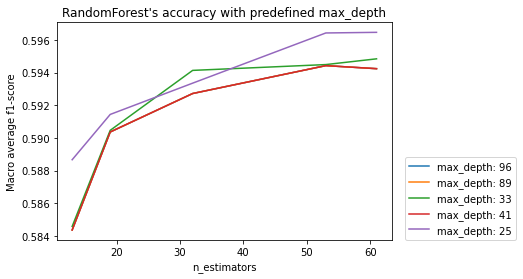

In [42]:
from utils.plot_utils import plot_score

macro_avg_f1_scores = dict(map(
    lambda z: (z, {'score': all_reports[z]['macro avg']['f1-score'][0],
                   'std': all_reports[z]['macro avg']['f1-score'][1]}),
    all_reports
))

plot_score(
    [macro_avg_f1_scores],
    ('n_estimators', 'max_depth'),
    'RandomForest',
    inverse=False,
    mode='score',
    in_same_graphic=True,
    accuracy_mode='accuracy',
    metric_name='Macro Average F1-Score'
)


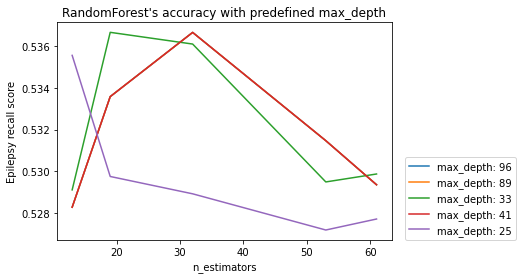

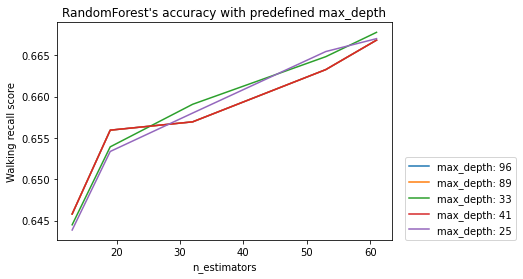

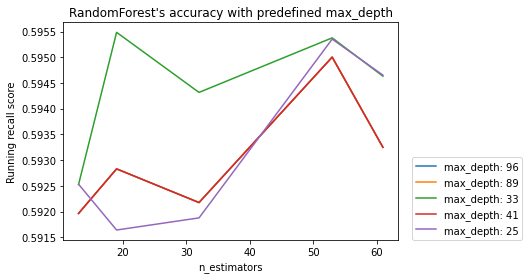

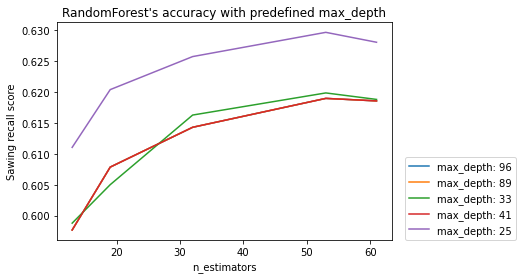

In [38]:
epilepsy_recall_scores = dict(map(
    lambda z: (z, {'score': all_reports[z]['epilepsy']['recall'][0],
                   'std': all_reports[z]['epilepsy']['recall'][1]}),
    all_reports
))

walking_recall_scores = dict(map(
    lambda z: (z, {'score': all_reports[z]['walking']['recall'][0],
                   'std': all_reports[z]['walking']['recall'][1]}),
    all_reports
))

running_recall_scores = dict(map(
    lambda z: (z, {'score': all_reports[z]['running']['recall'][0],
                   'std': all_reports[z]['running']['recall'][1]}),
    all_reports
))

sawing_recall_scores = dict(map(
    lambda z: (z, {'score': all_reports[z]['sawing']['recall'][0],
                   'std': all_reports[z]['sawing']['recall'][1]}),
    all_reports
))

plot_score(
    [epilepsy_recall_scores],
    ('n_estimators', 'max_depth'),
    'RandomForest',
    inverse=False,
    mode='score',
    in_same_graphic=True,
    accuracy_mode='accuracy',
    metric_name='Epilepsy recall score'
)

plot_score(
    [walking_recall_scores],
    ('n_estimators', 'max_depth'),
    'RandomForest',
    inverse=False,
    mode='score',
    in_same_graphic=True,
    accuracy_mode='accuracy',
    metric_name='Walking recall score'
)

plot_score(
    [running_recall_scores],
    ('n_estimators', 'max_depth'),
    'RandomForest',
    inverse=False,
    mode='score',
    in_same_graphic=True,
    accuracy_mode='accuracy',
    metric_name='Running recall score'
)

plot_score(
    [sawing_recall_scores],
    ('n_estimators', 'max_depth'),
    'RandomForest',
    inverse=False,
    mode='score',
    in_same_graphic=True,
    accuracy_mode='accuracy',
    metric_name='Sawing recall score'
)


## <font color=#cd0000> Evaluación sobre el conjunto de validación </font>
- Vamos a llevar a cabo la evaluación final sobre el conjunto de validación (esto es lo que irá al apartado de ``Pruebas y Resultados`` de la memoria).

### <font color=#cd0000> Entrenamiento </font>

In [12]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(
    n_estimators=61,
    max_depth=25,
    class_weight=class_weights,
    random_state=SEED
)
clf.fit(X_train, y_train)


RandomForestClassifier(class_weight={'epilepsy': 1.0073529411764706,
                                     'running': 0.9513888888888888,
                                     'sawing': 1.1416666666666666,
                                     'walking': 0.9256756756756757},
                       max_depth=25, n_estimators=61, random_state=1)

### <font color=#cd0000> Clasificación </font>

In [13]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

y_pred = clf.predict(X_test)
y_true = np.asarray(y_test)
    
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, zero_division=0))


[[3539 1038 1795  632]
 [1175 4693  637 1117]
 [1115  473 3841  751]
 [ 724 1046  702 5150]]
              precision    recall  f1-score   support

    epilepsy       0.54      0.51      0.52      7004
     running       0.65      0.62      0.63      7622
      sawing       0.55      0.62      0.58      6180
     walking       0.67      0.68      0.67      7622

    accuracy                           0.61     28428
   macro avg       0.60      0.60      0.60     28428
weighted avg       0.61      0.61      0.61     28428



# <font color=#cd0000> Conclusiones </font>
- Como podemos observar en los gráficos de tendencias parece que obtenemos un pico que se estabiliza entre los 40 y 60 estimadores mientras que, la profundidad de los árboles, no parece influir significativamente.
- Como ya veíamos anteriormente, este clasificador con la codificación actual no es el adecuado para enfrentarse a esta tarea de clasificación. 